In [2]:
# Feel free to import anything you need

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import ipdb
from tqdm import tqdm
import os

In [3]:
###########  Do not modify this cell ###########################
# ===============================================================

### seed everything for reproducibility
def seed_everything():
    seed = 24789
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 1. Contrastive learning loss functions

## 1(a) Implement the normalized temperature-scaled cross entropy loss (NT-Xent) based on SimCLR:
https://arxiv.org/pdf/2002.05709.pdf

\begin{equation}
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right) / \tau\right)}{\sum_{k=1}^{2 N}  \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)}
\end{equation}

In [4]:
def nt_xent(x, t=0.5):
    """
    1. Normalize across the second dimension
    2. Compute the normalized cosine similarity scores between x and its transpose
    3. Scale the normalized cosine similarity scores x_scores by dividing them by a temperature

    """
    t = torch.tensor(t, device= x.device)
    # 1. Normalize across the second dimension
    x = (x - torch.mean(x, dim = 0)) / torch.std(x, dim = 0)

    # 2. Compute the normalized cosine similarity scores between x and its transpose and scale the with temperature
    x_scores = F.cosine_similarity(x[None, :, :], x[:, None, :], dim= -1)

    # Subtract a diagonal matrix with large negative values from x_scale to set the diagonals to be zeros after softmax.
    #x_scale = x_scale - torch.eye(x_scale.size(0)).to(x_scale.device) * 1e5
    x_scores[torch.eye(x.size(0)).bool()] = float("-inf")

    # targets 2N elements.
    targets = torch.arange(x.size()[0], device= x.device)
    targets[::2] += 1  # target of 2k element is 2k+1
    targets[1::2] -= 1  # target of 2k+1 element is 2k

    # 3 . Compute the cross entropy loss between x_scale and target and return the computed loss
    loss = F.cross_entropy(x_scores/t, targets, reduction = "mean")
    #ipdb.set_trace()

    return loss

In [5]:
seed_everything()
z = torch.randn(4,3)
t = 0.7
loss = nt_xent(z, t)
print("z: \n", z)
print("Loss: \n", loss)

z: 
 tensor([[-0.2997, -0.6194, -0.4414],
        [-1.2945, -0.1358, -0.2589],
        [-0.7526,  0.4345, -0.9680],
        [ 0.8034, -2.5620,  0.9044]])
Loss: 
 tensor(1.8532)


## 1 (b) Implement Barlow twins loss function
https://arxiv.org/pdf/2103.03230.pdf


Cross correlation matrix
\begin{equation}
\mathcal{C}_{i j} \triangleq \frac{\sum_b z_{b, i}^A z_{b, j}^B}{\sqrt{\sum_b\left(z_{b, i}^A\right)^2} \sqrt{\sum_b\left(z_{b, j}^B\right)^2}}
\end{equation}
Barlow Twins loss

\begin{equation}
\mathcal{L}_{\mathcal{B} \mathcal{T}} \triangleq \sum_i\left(1-\mathcal{C}_{i i}\right)^2+\lambda \quad \sum_i \sum_{j \neq i} \mathcal{C}_{i j}^2
\end{equation}

In [6]:
def off_diag_elems(x):
    """
    Compute the flattened view of the off-diagonal elements of a matrix

    """
    #FILLIN
    n = x.shape[0]
    mask = torch.eye(n, dtype= bool, device= x.device)
    mask = ~mask
    off = x[mask].view(-1)
    #import ipdb; ipdb.set_trace()
    return off

def barlow_twins(z1, z2, lamda, batch_size):
    """
    z1 and z2 are the output image representations
    1. Normalize the representations across the batch dimension (dim=0)
    2. Compute the cross correlation matrix (given in the equation above)
    3. Compute the barlow twins loss by following the equations given above

    """
    #FILLIN
    z1 = (z1 - z1.mean(0)) / z1.std(0)
    z2 = (z2 - z2.mean(0)) / z2.std(0)

    #is this correct?
    cross_cor = (z1 @ z2.T) / batch_size

    loss = torch.sum((1 - torch.diagonal(cross_cor))**2) + lamda * torch.sum(off_diag_elems(cross_cor)**2)

    return loss

In [7]:
seed_everything()

N = 4
z1 = torch.randn(N, 4)
z2 = torch.randn(N, 4)
lamda = 5e-3

loss = barlow_twins(z1, z2, lamda, N)

print("z1: \n", z1)
print("z2: \n", z2)
print("Loss: \n", loss)

z1: 
 tensor([[-0.6637, -2.2035, -0.5497,  0.1591],
        [-0.8427, -0.3029, -1.2701, -0.8752],
        [ 0.1743, -0.6272, -0.5871, -1.7928],
        [-1.7089,  0.2134, -0.3203, -0.3736]])
z2: 
 tensor([[ 0.6968,  1.8388, -0.9387, -0.4800],
        [-1.4524,  1.3257,  0.9204, -0.5180],
        [-1.0516, -0.5895,  0.5390,  0.0944],
        [-1.7974,  0.0804,  0.7257,  0.9933]])
Loss: 
 tensor(5.5671)


# 2. Implement the SimCLR model

In [8]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim):
        super().__init__()
        self.enc = base_encoder(weights=False)
        self.feature_dim = self.enc.fc.in_features

        # Modifying the base encoder as mentioned in B4 of SimCLR
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):

        ######## Define the forward function ############################
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection


In [9]:
###########  Do not modify this cell ###########################
# ===============================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Creating pairs of image on the training set

In [10]:
###########  Do not modify this cell ###########################
# ===============================================================

class CIFAR10Pair(CIFAR10):
    """Generate mini-batche pairs on CIFAR10 training set."""
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img)
        imgs = [self.transform(img), self.transform(img)]
        return torch.stack(imgs), target  # stack a positive pair

#3. Define the transformations, dataloaders, model, optimizer, scheduler and parameters required for training

In [11]:
############ Define the parameters for training ##############
#as high batch size as possible as per paper 256 - 8192, use lars stabiloizer since sgd/momentum is bad for high batch size
batch_size = 128
projection_dim = 128
learning_rate =  0.15
momentum = 0.9
weight_decay = 10e-6
epochs = 100

print(5e-5)

5e-05


In [12]:
assert torch.cuda.is_available()
cudnn.benchmark = True

######### Define the transformation on the training set
### Refer to the paper to understand which transformations to use ######
#random cropping followed by resize back to the original size, random color distortions, and random Gaussian blur

train_transform = transforms.Compose([
    transforms.RandomCrop((8, 8)),
    transforms.Resize((32, 32)),
    transforms.GaussianBlur(kernel_size= 3),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

##### get absolute path of data dir

data_dir = "/content"


########## Define the train set and train dataloader and shuffle the train set

train_set = CIFAR10Pair(root=data_dir,
                        train=True,
                        transform=train_transform,
                        download=True)

train_loader = DataLoader(train_set, batch_size= batch_size, shuffle= True)




100%|██████████| 170498071/170498071 [00:12<00:00, 13120219.78it/s]


Extracting /content/cifar-10-python.tar.gz to /content


In [14]:
######## Define the base encoder(resnet18) -- load from torchvision.models without pretraining

base_encoder = torchvision.models.resnet18
model = SimCLR(base_encoder= base_encoder, projection_dim= projection_dim)
#model.load_state_dict(torch.load("simclr_epoch71.pth"))
model = model.cuda()

########### Define the optimizer and scheduler for training #######################

#supposed to use LARS
optimizer = optim.SGD(params= model.parameters(), lr = learning_rate, momentum= momentum, weight_decay= weight_decay)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer= optimizer, T_0= 10, T_mult= 1)


In [15]:
def train(args) -> None:
    # SimCLR training
    model.train()
    best_loss = np.inf
    for epoch in range(1, args['epochs'] + 1):
        loss_meter = AverageMeter("SimCLR_loss")
        train_bar = tqdm(train_loader)
        for x, y in train_bar:
            sizes = x.size()
            #ipdb.set_trace()
            x = x.view(sizes[0] * 2, sizes[2], sizes[3], sizes[4]).cuda(non_blocking=True)
            #ipdb.set_trace()
            optimizer.zero_grad()

            ####### Get the output from the model ################

            feature, rep = model(x)

            ###### Compute the loss using nt-cross entropy loss  #####################################
            #ipdb.set_trace()

            loss = nt_xent(rep, args["temperature"])
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_meter.update(loss.item(), x.size(0))
            train_bar.set_description("Train epoch {}, SimCLR loss: {:.4f}".format(epoch, loss_meter.avg))
            if loss.item() < best_loss:
                best_loss = loss.item()
                PATH = "simclr_best_epoch.pth"
                #ipdb.set_trace()
                #torch.save(model.state_dict(), file_path)
                if os.path.exists(PATH):
                    os.remove(PATH)
                torch.save(model.state_dict(), PATH)


In [16]:
args = {
    'epochs':  epochs,
    'batch_size':  batch_size,
    'temperature': 0.7,
}

#commenting out the training call
#train(args)

# Finetuning and testing the saved model

In [39]:
###########  Do not modify this cell ###########################
# ===============================================================
class LinModel(nn.Module):
    """Linear wrapper of encoder."""
    def __init__(self, encoder: nn.Module, feature_dim: int, n_classes: int):
        super().__init__()
        self.enc = encoder
        self.feature_dim = feature_dim
        self.n_classes = n_classes
        self.lin = nn.Linear(self.feature_dim, self.n_classes)

    def forward(self, x):
        x = self.enc(x)
        x = self.lin(x)
        return x

In [40]:
###########  Do not modify this cell ###########################
# ===============================================================

def run_epoch(model, dataloader, epoch, optimizer=None, scheduler=None):
    if optimizer:
        model.train()
        print("training...........")
    else:
        model.eval()
        print("eval...............")

    loss_meter = AverageMeter('loss')
    acc_meter = AverageMeter('acc')
    loader_bar = tqdm(dataloader)
    for x, y in loader_bar:
        x, y = x.cuda(), y.cuda()
        #ipdb.set_trace()
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        acc = (logits.argmax(dim=1) == y).float().mean()
        loss_meter.update(loss.item(), x.size(0))
        acc_meter.update(acc.item(), x.size(0))
        if optimizer:
            loader_bar.set_description("Train epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))
        else:
            loader_bar.set_description("Test epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))

    return loss_meter.avg, acc_meter.avg

In [41]:
############################################ Define train and test transforms #########################################################
### Refer to the paper to understand which transformations to use ######

batch_size = 256
learning_rate = 0.3
epochs = 10

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale =(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p = 0.8),
    transforms.RandomGrayscale(p= 0.2),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size= 3, sigma = (0.1, 2.0)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

data_dir = '/content'

###################################### Define train and test dataloader #########################################

train_set = CIFAR10(root=data_dir,
                        train=True,
                        transform=train_transform,
                        download=True)
test_set = CIFAR10(root=data_dir,
                        train=False,
                        transform=test_transform,
                        download=True)

n_classes = 10

train_loader = DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle= True)

################################ Define the model and load the trained weights of the best model ##############################
"""
Load the weights for the best SimCLR model and pass the encoder to LinModel for fine-tuning
"""
base_encoder = torchvision.models.resnet18
pre_model = SimCLR(base_encoder= base_encoder, projection_dim= projection_dim)
pre_model.load_state_dict(torch.load("simclr_best_epoch.pt"))
model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=len(train_set.targets))
#loading a previous run model
#model.load_state_dict(torch.load("simclr_lin_best.pt"))
model = model.cuda()

# Fix encoder
model.enc.requires_grad = False
parameters = [param for param in model.parameters() if param.requires_grad is True]  # trainable parameters.

############################# Define the optimizer and scheduler ###################################################
optimizer = optim.SGD(params= parameters, lr = learning_rate, momentum= momentum, weight_decay= weight_decay)

#No restart, and warmup 10, and cosine lr_sceduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer= optimizer, T_0= 10, T_mult= 1)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [42]:
###########  Do not modify this cell ###########################
# ===============================================================

def finetune() -> None:
    optimal_loss, optimal_acc = 1e5, 0.
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, epoch, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = run_epoch(model, test_loader, epoch)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        if train_loss < optimal_loss:
            optimal_loss = train_loss
            optimal_acc = test_acc
            torch.save(model.state_dict(), 'simclr_lin_best.pt')

    return train_losses, train_accuracies, test_losses, test_accuracies

In [43]:
###########  Do not modify this cell ###########################
# ===============================================================

train_losses, train_accuracies, test_losses, test_accuracies = finetune()



training...........


Train epoch 1, loss: 0.7109, acc: 0.7512: 100%|██████████| 196/196 [02:11<00:00,  1.49it/s]


eval...............


Test epoch 1, loss: 0.5169, acc: 0.8221: 100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


training...........


Train epoch 2, loss: 0.6460, acc: 0.7756: 100%|██████████| 196/196 [02:12<00:00,  1.48it/s]


eval...............


Test epoch 2, loss: 0.4664, acc: 0.8371: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


training...........


Train epoch 3, loss: 0.6288, acc: 0.7793: 100%|██████████| 196/196 [02:13<00:00,  1.47it/s]


eval...............


Test epoch 3, loss: 0.4409, acc: 0.8464: 100%|██████████| 40/40 [00:05<00:00,  7.08it/s]


training...........


Train epoch 4, loss: 0.6064, acc: 0.7873: 100%|██████████| 196/196 [02:15<00:00,  1.45it/s]


eval...............


Test epoch 4, loss: 0.4239, acc: 0.8536: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


training...........


Train epoch 5, loss: 0.5729, acc: 0.8001: 100%|██████████| 196/196 [02:14<00:00,  1.45it/s]


eval...............


Test epoch 5, loss: 0.4308, acc: 0.8530: 100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


training...........


Train epoch 6, loss: 0.5601, acc: 0.8045: 100%|██████████| 196/196 [02:12<00:00,  1.48it/s]


eval...............


Test epoch 6, loss: 0.4042, acc: 0.8582: 100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


training...........


Train epoch 7, loss: 0.5385, acc: 0.8141: 100%|██████████| 196/196 [02:12<00:00,  1.48it/s]


eval...............


Test epoch 7, loss: 0.3949, acc: 0.8670: 100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


training...........


Train epoch 8, loss: 0.5316, acc: 0.8147: 100%|██████████| 196/196 [02:12<00:00,  1.48it/s]


eval...............


Test epoch 8, loss: 0.4140, acc: 0.8601: 100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


training...........


Train epoch 9, loss: 0.5203, acc: 0.8176: 100%|██████████| 196/196 [02:11<00:00,  1.49it/s]


eval...............


Test epoch 9, loss: 0.4248, acc: 0.8563: 100%|██████████| 40/40 [00:05<00:00,  7.13it/s]


training...........


Train epoch 10, loss: 0.5063, acc: 0.8218: 100%|██████████| 196/196 [02:13<00:00,  1.46it/s]


eval...............


Test epoch 10, loss: 0.3574, acc: 0.8792: 100%|██████████| 40/40 [00:05<00:00,  7.95it/s]


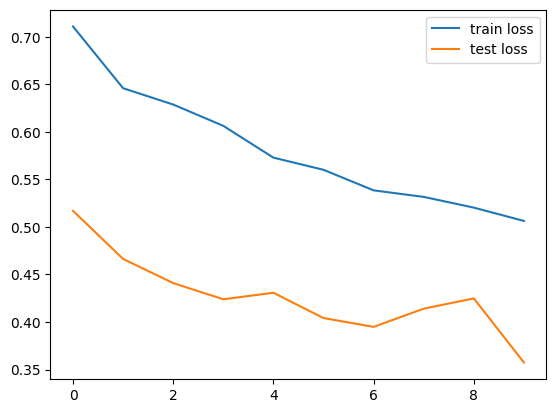

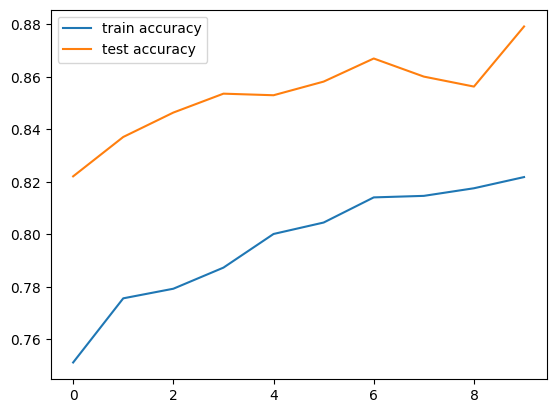

In [44]:
plt.plot(train_losses, label='train loss')  # simply visualize the training loss
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='train accuracy')  # simply visualize the training loss
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

# Transforms for simCLR
<br>
 <br>
 train_transform 
<br>

transforms.Compose([
    transforms.RandomCrop((8, 8)),
    transforms.Resize((32, 32)),
    transforms.GaussianBlur(kernel_size= 3),
    transforms.ColorJitter(),
    transforms.ToTensor()
])
<br>
<br>
 
 
# Transform for fine tuning :
<br>
<br>
 train_transform

<br>
transforms.Compose([
    transforms.RandomResizedCrop(32, scale =(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p = 0.8),
    transforms.RandomGrayscale(p= 0.2),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size= 3, sigma = (0.1, 2.0)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])
<br>
<br>
<br>
 test_transform
<br>
transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])
